In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from sklearn import manifold, datasets
from time import time
import torch
from models.ViT_CCT import ViT_CCT, Conditions
from sklearn.manifold import TSNE
from configs.configs_training import *
from main import *
from matplotlib import colors as mcolors

In [2]:
import argparse

In [29]:
ds_name = 'CropDisease'
# ds_name = 'EuroSAT'
# ds_name = 'ISIC'
# ds_name = 'ChestX'

In [30]:
args = argparse.Namespace(output_file='/run/media/user/Data/Saves_Adapter/Saves-miniImageNet-' + ds_name + '/P2e-Epoch=200', 
                          input_file='/run/media/user/Data/Saves_Adapter/Saves-miniImageNet-' + ds_name + '/P2e-Epoch=200', 
                          target_subset_split='datasets/split_seed_1/' + ds_name + '_labeled_80.csv', 
                          subset_split='datasets/split_seed_1/' + ds_name + '_labeled_80.csv', 
                          phase='fsl', 
                          base_dataset='miniImageNet', 
                          target_dataset=ds_name, 
                          batch_size=10,
                          experiment_name='', 
                          log_file='/run/media/user/Data/Saves_Adapter/temp.txt', 
                          reproducible=True, 
                          device='cuda', 
                          aug_train=True, 
                          force_cpu=False, 
                          time_interval_to_save=60.0, 
                          load_path=None, 
                          resume_latest=False, 
                          seed=1, 
                          num_workers=4, 
                          in_channels=3, 
                          n_ways=5, 
                          n_shots=5, 
                          n_episodes=600, 
                          n_queries=15, 
                          use_LGC=True, 
                          LP_with_support_set=False, 
                          one_hot_logits_for_support_set=False, 
                          base_path=None, 
                          base_split=None, 
                          base_val_ratio=0.05, 
                          target_path=None, 
                          num_classes_base=-1, 
                          num_classes_target=-1, 
                          image_size=224, 
                          model_type='CCT-14/7x2', 
                          n_epochs=500, 
                          n_iterations=200000, 
                          display_freq=200, 
                          display_interval=0.5, 
                          learning_rate=0.00025, 
                          save_freq_epoch=5, 
                          save_freq_iter=2000, 
                          eval_freq=1, 
                          print_freq=5, 
                          momentum=0.9, 
                          freeze_backbone=True, 
                          n_layers_classifier=2, 
                          n_estimators_classifier=2, 
                          inference_use_pretrained_head=False, 
                          domain_dino='target', 
                          out_dim=65536, 
                          norm_last_layer=True, 
                          local_crops_number=8, 
                          local_crops_scale=(0.05, 0.4), 
                          warmup_teacher_temp=0.04, 
                          teacher_temp=0.04, warmup_teacher_temp_epochs=0, weight_decay=1e-05, 
                          weight_decay_end=0.4, min_lr=5e-07, warmup_epochs=10, 
                          global_crops_scale=(0.4, 1.0), momentum_teacher=0.996, clip_grad=3.0, 
                          freeze_last_layer=1, use_bn_in_head=False)

In [31]:
configs = ConfigurationTraining(args)

The network was trained for 200 epochs, 0 iterations
We continue from epoch 0, iteration 0
File "/run/media/user/Data/Saves_Adapter/Saves-miniImageNet-CropDisease/P2e-Epoch=200.zip" is loaded
Batch size = 10


--------------------------------------------------------------------------------
--> The weights of the teacher model is loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head_base.mlp.0.weight', 'head_base.mlp.0.bias', 'head_base.mlp.2.weight', 'head_base.mlp.2.bias', 'head_base.mlp.4.weight', 'head_base.mlp.4.bias', 'head_base.last_layer.weight_g', 'head_base.last_layer.weight_v', 'head_target.mlp.0.weight', 'head_target.mlp.0.bias', 'head_target.mlp.2.weight', 'head_target.mlp.2.bias', 'head_target.mlp.4.weight', 'head_target.mlp.4.bias', 'head_target.last_layer.weight_g', 'head_target.last_layer.weight_v'])


In [32]:
configs.set_seed()

dataloader = load_target_dataset_student(configs, 
                                         configs.batch_size,
                                         False,
                                         split_to_train_val=False,
                                         shuffle_for_train_loader=True,
                                         drop_last_for_train_loader=False,
                                         dataloader_or_dataset=True)

Using Split:  datasets/split_seed_1/CropDisease_labeled_80.csv
Size of target dataset 34765


In [33]:
model = configs.get_the_model()
model.eval();

In [34]:
x = None
y = None
features_list = []
y_list = []
cnt = 0
with torch.no_grad():
    for x_base, y_base in dataloader:
        y_list.append(y_base)
        features = model(Conditions.single_self_attention, {'x': x_base.to(configs.device)})
        features_list.append(features)
        cnt += configs.batch_size
        temp = torch.cat(y_list, dim=0)
        if len(temp[temp<10]) > 2000:
            break

In [35]:
x = torch.cat(features_list, dim=0)
y = torch.cat(y_list, dim=0)
print(y.max())

tensor(37)


In [36]:
selected = y < 10
x = x[selected][:2000]
y = y[selected][:2000]

In [37]:
# x = x[:1000]
# y = y[:1000]

In [38]:
print(y.shape)
print(y.max())

torch.Size([2000])
tensor(9)


In [39]:
x = x.cpu().detach().numpy()

In [40]:
tsne = TSNE(n_components=2, 
            learning_rate='auto',
            init='random', 
            perplexity=30,
            random_state=10)

X_embedded = tsne.fit_transform(x)

In [41]:
colors = np.array(list(dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)))

In [42]:
# colors

In [43]:
colors = np.array(['b', 'g', 'r', 'c', 'm', 'brown', 'k', 'navy', 'orange', 'violet', 'olive', 'pink', 'orangered', 'orchid', 'papayawhip', 'peachpuff',
       'peru', 'plum', 'powderblue', 'purple', 'rebeccapurple',
       'rosybrown', 'royalblue', 'saddlebrown', 'salmon',
       'sandybrown', 'seagreen', 'seashell', 'sienna',
       'skyblue', 'slateblue', 'slategray', 'slategrey',
       'springgreen', 'steelblue', 'thistle', 'tomato',
       'turquoise', 'wheat', 'olive', 'silver',
       'yellowgreen', 'palegreen',
       'paleturquoise', 'palevioletred', 'palegoldenrod', 'olivedrab', 'oldlace', 'silver', 'tan', 'teal'])

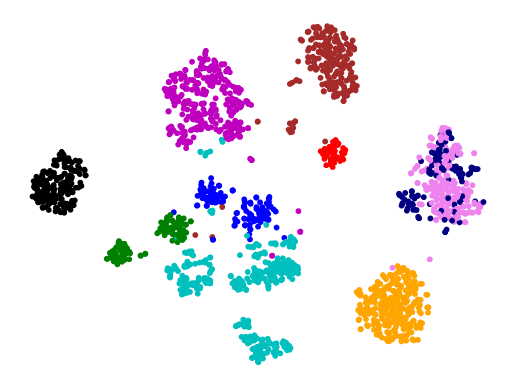

In [45]:
plt.axis('off')
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=colors[y], s=10)